# Google Analytics Capstone Project

I decided to use multi-labeled single classsification to classify the different type of visitors in the website. This could help the digital marketing team to create their marketing efforts depending on the type of visitors. <br>
I will use feature iteration to get my final Machine Learning Model: <br>
**1st:** date, source/medium and device category <br>
**2nd:** date, source/medium, device category, gender, type of visitors and age <br>
**3rd:** date, source/medium, device category, gender, type of visitors, age, *adwords*, *audience*, *ad_content* <br>
***italics*** means optional, due to its validity in the model

## Preparation

Import libraries needed to get, clean, and prepare the dataset

In [1]:
#Packages needed for authentication
import httplib2 as lib2
from oauth2client import client

#Packages needed for connecting with Google API
from googleapiclient.discovery import build as google_build

#Data processing packages
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

Connecting to the Google Analytics API

In [2]:
#This section is for setting up the API requests
#This is to establish our identity for requests
access_token = ""
refresh_token = ""
client_id = ""
client_secret = ""

#This is consistent for all Google services
token_uri = 'https://accounts.google.com/o/oauth2/token'

#We are essentially setting the expiry date to 1 day before today, which will make it always expire
token_expiry = datetime.now() - timedelta(days = 1)

#¯\_(ツ)_/¯
user_agent = 'my-user-agent/1.0'

#The real code that initalized the client
credentials = client.GoogleCredentials(access_token=access_token, refresh_token=refresh_token, 
                                       client_id=client_id, client_secret=client_secret, 
                                       token_uri=token_uri, token_expiry=token_expiry, 
                                       user_agent=user_agent)

#Initialize Http Protocol    
http = lib2.Http()

#Authorize client
authorized = credentials.authorize(http)

In [3]:
#API Name and Verison, these don't change until 
#they release a new API version for us to play with. 
api_name = 'analyticsreporting'
api_version = 'v4'

#Let's build the client
api_client = google_build(serviceName=api_name, version=api_version, http=authorized)

Defining the functions we will use later

In [4]:
#define parser function to be used later
def parse_response(report):

    """Parses and prints the Analytics Reporting API V4 response"""
    #Initialize results, in list format because two dataframes might return
    result_list = []

    #Initialize empty data container for the two dateranges (if there are two that is)
    data_csv = []
    data_csv2 = []

    #Initialize header rows
    header_row = []

    #Get column headers, metric headers, and dimension headers.
    columnHeader = report.get('columnHeader', {})
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    dimensionHeaders = columnHeader.get('dimensions', [])

    #Combine all of those headers into the header_row, which is in a list format
    for dheader in dimensionHeaders:
        header_row.append(dheader)
    for mheader in metricHeaders:
        header_row.append(mheader['name'])

    #Get data from each of the rows, and append them into a list
    rows = report.get('data', {}).get('rows', [])
    for row in rows:
        row_temp = []
        dimensions = row.get('dimensions', [])
        metrics = row.get('metrics', [])
        for d in dimensions:
            row_temp.append(d)
        for m in metrics[0]['values']:
            row_temp.append(m)
            data_csv.append(row_temp)

        #In case of a second date range, do the same thing for the second request
        if len(metrics) == 2:
            row_temp2 = []
            for d in dimensions:
                row_temp2.append(d)
            for m in metrics[1]['values']:
                row_temp2.append(m)
            data_csv2.append(row_temp2)

    #Putting those list formats into pandas dataframe, and append them into the final result
    result_df = pd.DataFrame(data_csv, columns=header_row)
    result_list.append(result_df)
    if data_csv2 != []:
        result_list.append(pd.DataFrame(data_csv2, columns=header_row))

    return result_list

In [5]:
#given dates that will be used for API call
from datetime import date
from dateutil.rrule import rrule, DAILY
import time

a = date(2019, 1, 1)
b = date(2019, 4, 1)

print('Below proves that dateutil package is working:')
for dt in rrule(DAILY, dtstart=a, until=b):
    print(dt.strftime("%Y-%m-%d"))

dates = list(rrule(DAILY, dtstart=a, until=b))

Below proves that dateutil package is working:
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03

In [7]:
#function to query GA API
def get_data(query_param):
    '''
    query_param: dictionary format for API call
       returns: DataFrame of query_param
    '''
    response = api_client.reports().batchGet(
      body={
        'reportRequests': query_param
      }).execute()
    #parsed response
    report = response.get('reports', [])[0]
    report_df = parse_response(report)[0]
    return report_df

## Final Iteration

**Features:** <br>
date, source/medium, device category, gender, type of visitors, age, adwords, audience, ad_content <br>
**Predictors:** <br>
bounces / sessions, goal1 completions / sessions, goal abandonments / sessions <br>

**Definition of features:** <br>
* date: stores year, month, day and hour
* user_type: new/returning users from the website
* gender: male/female
* age: *NOT POSSIBLE*
* device_category: mobile/desktop/tablet
* source_medium: source of traffic of a user (google, facebook, email, etc.) and on what type of referral was made by the source (cpc means paid, organic means non-paid, etc.)
* ad_content: contains the utm tagging that the team uses for the team’s campaign
* adwords:
* audience:
* sessions:
* bounces: number of sessions a user had without interacting with the website
* goal completions:
* goal abandonments:

In [16]:
#query an API call using the looped date and query function
merged = []
for i in range(len(dates)-1):
    print(dates[i], dates[i+1])
    start = dates[i].strftime("%Y-%m-%d")
    end = dates[i+1].strftime("%Y-%m-%d")  
    query1 = {
      "viewId": "",
      "dateRanges": [{ "startDate": start, "endDate": end }],
      "dimensions": [
        { "name": "ga:dateHourMinute" },
        #{ "name": "ga:daysSinceLastSession" },
        #{ "name": "ga:userType" },
        { "name": "ga:userGender" },
        { "name": "ga:userAgeBracket" },
        #{ "name": "ga:city" },
        #{ "name": "ga:interestAffinityCategory" },
        { "name": "ga:deviceCategory" },
        { "name": "ga:sourceMedium" },
        { "name": "ga:adContent" }
        
      ],
      "metrics": [
        { "expression": "ga:sessions" },
        { "expression": "ga:bounces"},
        { "expression":  "ga:goalCompletionsAll" },
        { "expression": "ga:goalAbandonsAll" }
      ],
      "samplingLevel": "LARGE",
      "pageSize": 50000
    }
    df = get_data(query1)
    #df.shape
    #list the identifier columns
    #cols = ['ga:dateHour', 'ga:dayOfWeek', 'ga:userType', 'ga:userGender', 'ga:deviceCategory', 'ga:sourceMedium', 'ga:adContent', 'ga:pageTitle', 'ga:exitPagePath']
    #merging all of my engagement dataFrames with same dimensions but different metrics
    #merge1 = pd.merge(acquisition1A, acquisition1B, on = cols, how='inner')
    merged.append(df)
    final_df = pd.concat(merged)
    
    print(final_df.shape)

2019-01-01 00:00:00 2019-01-02 00:00:00
(0, 10)
2019-01-02 00:00:00 2019-01-03 00:00:00
(4, 10)
2019-01-03 00:00:00 2019-01-04 00:00:00
(16, 10)
2019-01-04 00:00:00 2019-01-05 00:00:00
(24, 10)
2019-01-05 00:00:00 2019-01-06 00:00:00
(24, 10)
2019-01-06 00:00:00 2019-01-07 00:00:00
(24, 10)
2019-01-07 00:00:00 2019-01-08 00:00:00
(24, 10)
2019-01-08 00:00:00 2019-01-09 00:00:00
(24, 10)
2019-01-09 00:00:00 2019-01-10 00:00:00
(24, 10)
2019-01-10 00:00:00 2019-01-11 00:00:00
(24, 10)
2019-01-11 00:00:00 2019-01-12 00:00:00
(24, 10)
2019-01-12 00:00:00 2019-01-13 00:00:00
(24, 10)
2019-01-13 00:00:00 2019-01-14 00:00:00
(28, 10)
2019-01-14 00:00:00 2019-01-15 00:00:00
(88, 10)
2019-01-15 00:00:00 2019-01-16 00:00:00
(148, 10)
2019-01-16 00:00:00 2019-01-17 00:00:00
(152, 10)
2019-01-17 00:00:00 2019-01-18 00:00:00
(168, 10)
2019-01-18 00:00:00 2019-01-19 00:00:00
(184, 10)
2019-01-19 00:00:00 2019-01-20 00:00:00
(184, 10)
2019-01-20 00:00:00 2019-01-21 00:00:00
(196, 10)
2019-01-21 00:00

In [8]:
#query an API call using the looped date and query function
merged = []
for i in range(len(dates)-1):
    print(dates[i], dates[i+1])
    start = dates[i].strftime("%Y-%m-%d")
    end = dates[i+1].strftime("%Y-%m-%d")  
    query1 = {
      "viewId": "",
      "dateRanges": [{ "startDate": start, "endDate": end }],
      "dimensions": [
        { "name": "ga:dateHourMinute" },
        #{ "name": "ga:daysSinceLastSession" },
        #{ "name": "ga:userType" },
        { "name": "ga:userGender" },
        #{ "name": "ga:userAgeBracket" },
        #{ "name": "ga:city" },
        #{ "name": "ga:interestAffinityCategory" },
        { "name": "ga:deviceCategory" },
        { "name": "ga:sourceMedium" },
        { "name": "ga:adContent" }
        
      ],
      "metrics": [
        { "expression": "ga:sessions" },
        { "expression": "ga:bounces"},
        { "expression":  "ga:goalCompletionsAll" },
        { "expression": "ga:goalAbandonsAll" }
      ],
      "samplingLevel": "LARGE",
      "pageSize": 50000
    }
    df = get_data(query1)
    #df.shape
    #list the identifier columns
    #cols = ['ga:dateHour', 'ga:dayOfWeek', 'ga:userType', 'ga:userGender', 'ga:deviceCategory', 'ga:sourceMedium', 'ga:adContent', 'ga:pageTitle', 'ga:exitPagePath']
    #merging all of my engagement dataFrames with same dimensions but different metrics
    #merge1 = pd.merge(acquisition1A, acquisition1B, on = cols, how='inner')
    merged.append(df)
    final_df2 = pd.concat(merged)
    
    print(final_df2.shape)

2019-01-01 00:00:00 2019-01-02 00:00:00
(100, 9)
2019-01-02 00:00:00 2019-01-03 00:00:00
(384, 9)
2019-01-03 00:00:00 2019-01-04 00:00:00
(764, 9)
2019-01-04 00:00:00 2019-01-05 00:00:00
(960, 9)
2019-01-05 00:00:00 2019-01-06 00:00:00
(964, 9)
2019-01-06 00:00:00 2019-01-07 00:00:00
(1096, 9)
2019-01-07 00:00:00 2019-01-08 00:00:00
(1344, 9)
2019-01-08 00:00:00 2019-01-09 00:00:00
(1564, 9)
2019-01-09 00:00:00 2019-01-10 00:00:00
(1808, 9)
2019-01-10 00:00:00 2019-01-11 00:00:00
(1984, 9)
2019-01-11 00:00:00 2019-01-12 00:00:00
(2020, 9)
2019-01-12 00:00:00 2019-01-13 00:00:00
(2028, 9)
2019-01-13 00:00:00 2019-01-14 00:00:00
(2244, 9)
2019-01-14 00:00:00 2019-01-15 00:00:00
(2960, 9)
2019-01-15 00:00:00 2019-01-16 00:00:00
(3524, 9)
2019-01-16 00:00:00 2019-01-17 00:00:00
(3672, 9)
2019-01-17 00:00:00 2019-01-18 00:00:00
(3840, 9)
2019-01-18 00:00:00 2019-01-19 00:00:00
(3924, 9)
2019-01-19 00:00:00 2019-01-20 00:00:00
(3928, 9)
2019-01-20 00:00:00 2019-01-21 00:00:00
(4032, 9)
2019-

In [10]:
pd.set_option('display.max_columns', 50)
final_df2

,ga:dateHourMinute,ga:userGender,ga:deviceCategory,ga:sourceMedium,ga:adContent,ga:sessions,ga:bounces,ga:goalCompletionsAll,ga:goalAbandonsAll
0,201901020906,female,desktop,google / organic,(not set),3,3,0,0
1,201901020906,female,desktop,google / organic,(not set),3,3,0,0
2,201901020906,female,desktop,google / organic,(not set),3,3,0,0
3,201901020906,female,desktop,google / organic,(not set),3,3,0,0
4,201901021014,female,desktop,google / organic,(not set),5,3,0,0
5,201901021014,female,desktop,google / organic,(not set),5,3,0,0
6,201901021014,female,desktop,google / organic,(not set),5,3,0,0
7,201901021014,female,desktop,google / organic,(not set),5,3,0,0
8,201901021118,female,desktop,google / organic,(not set),3,2,0,2
9,201901021118,female,desktop,google / organic,(not set),3,2,0,2


In [14]:
display(final_df2['ga:goalCompletionsAll'].value_counts())
display(final_df2['ga:goalAbandonsAll'].value_counts())
display(final_df2['ga:adContent'].value_counts())
display(final_df2["ga:userGender"].value_counts())
display(final_df2["ga:sourceMedium"].value_counts())

0    10964
1      760
2      356
3       48
Name: ga:goalCompletionsAll, dtype: int64

0    6544
1    3928
2    1380
3     248
4      28
Name: ga:goalAbandonsAll, dtype: int64

(not set)                                        11888
accounts-xaccgold-welcome-030119-xrass             184
accounts-xaccgeneral-debitraffle-112218-xrass       48
accounts-xaccallaccess-draffle-110618-xrass          8
Name: ga:adContent, dtype: int64

female    11628
male        500
Name: ga:userGender, dtype: int64

google / organic    11160
google / cpc          728
offline / sms         240
Name: ga:sourceMedium, dtype: int64

**Save dataset, so I don't need to run it anymore**

In [16]:
final_df2.to_csv(r'C:\Users\207915\Documents\Python_sandbox\classification_model.csv', index=False, header=True)

In [2]:
ga_class = pd.read_csv('classification_model.csv')
ga_class.columns

Index(['ga:dateHourMinute', 'ga:userGender', 'ga:deviceCategory',
       'ga:sourceMedium', 'ga:adContent', 'ga:sessions', 'ga:bounces',
       'ga:goalCompletionsAll', 'ga:goalAbandonsAll'],
      dtype='object')

In [3]:
print(ga_class.shape)
print(ga_class['ga:goalCompletionsAll'].value_counts(), ga_class['ga:goalAbandonsAll'].value_counts(), ga_class['ga:bounces'].value_counts(), ga_class['ga:sessions'].value_counts())

(12128, 9)
0    10964
1      760
2      356
3       48
Name: ga:goalCompletionsAll, dtype: int64 0    6544
1    3928
2    1380
3     248
4      28
Name: ga:goalAbandonsAll, dtype: int64 2     2752
3     2736
4     2184
1     1476
5     1216
6      584
0      380
7      312
8      208
9      168
10      48
11      40
12      16
13       8
Name: ga:bounces, dtype: int64 5     2556
6     2424
4     1816
7     1660
8     1224
3      924
9      468
2      336
10     224
11     200
12      80
1       80
13      56
17      16
18      16
19      16
25       8
14       8
32       8
0        8
Name: ga:sessions, dtype: int64


**Proceed to Data Cleaning** <br>
I will extract features to get the date, source and medium columns. I will also use one-hot encoding for categorical variables device, source and medium.

In [4]:
ga_class.head()

,ga:dateHourMinute,ga:userGender,ga:deviceCategory,ga:sourceMedium,ga:adContent,ga:sessions,ga:bounces,ga:goalCompletionsAll,ga:goalAbandonsAll
0,201901020906,female,desktop,google / organic,(not set),3,3,0,0
1,201901020906,female,desktop,google / organic,(not set),3,3,0,0
2,201901020906,female,desktop,google / organic,(not set),3,3,0,0
3,201901020906,female,desktop,google / organic,(not set),3,3,0,0
4,201901021014,female,desktop,google / organic,(not set),5,3,0,0


In [5]:
#df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d%H%M'))
ga_class['ga:dateHourMinute'] = ga_class['ga:dateHourMinute'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d%H%M'))

In [6]:
ga_class['month'] = ga_class['ga:dateHourMinute'].apply(lambda x: (x.month))
ga_class['day'] = ga_class['ga:dateHourMinute'].apply(lambda x: (x.day))
ga_class['hour'] = ga_class['ga:dateHourMinute'].apply(lambda x: (x.hour))
ga_class['minute'] = ga_class['ga:dateHourMinute'].apply(lambda x: (x.minute))

In [7]:
ga_class.head(10)

,ga:dateHourMinute,ga:userGender,ga:deviceCategory,ga:sourceMedium,ga:adContent,ga:sessions,ga:bounces,ga:goalCompletionsAll,ga:goalAbandonsAll,month,day,hour,minute
0,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,1,2,9,6
1,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,1,2,9,6
2,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,1,2,9,6
3,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,1,2,9,6
4,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,1,2,10,14
5,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,1,2,10,14
6,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,1,2,10,14
7,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,1,2,10,14
8,2019-01-02 11:18:00,female,desktop,google / organic,(not set),3,2,0,2,1,2,11,18
9,2019-01-02 11:18:00,female,desktop,google / organic,(not set),3,2,0,2,1,2,11,18


In [8]:
ga_class = ga_class.drop(columns='ga:dateHourMinute')

In [9]:
# lets replace the name of the columns first
cols = ['gender', 'device', 'source_medium', 'ad_content', 'sessions', 'bounces', 'goals', 'abandons', 'month', 'day', 'hour', 'minute']
ga_class.columns = cols
ga_class.columns

Index(['gender', 'device', 'source_medium', 'ad_content', 'sessions',
       'bounces', 'goals', 'abandons', 'month', 'day', 'hour', 'minute'],
      dtype='object')

Compute the bounce rates, completion rates and abandon rates. Then, I will create a threshold that will label the row: bouncer, converter, abandoner and others

In [10]:
# get the source and medium features
ga_class['source'] = ga_class['source_medium'].str.split('/').str.get(0)
ga_class['medium'] = ga_class['source_medium'].str.split('/').str.get(1)

In [11]:
# investigate ad_content to get the features necessary
utm = ga_class.ad_content
utm_split = utm.str.split('-')
utm_subproduct = []
utm_promo = []
utm_description = []
utm_placement = []

for utm in utm_split:
    if utm[0][0:2] == 'FB':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append(utm[3]) 
        utm_placement.append('None')
    elif utm[0][0:2] == 'EM':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append('None') 
        utm_placement.append(utm[3])
    elif utm[-1][0] == 'x':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append('None') 
        utm_placement.append('None')
    else:
        utm_subproduct.append('None')
        utm_promo.append('None')
        utm_description.append(utm[0]) 
        utm_placement.append('None')
        
ga_class['subproduct'] = utm_subproduct
ga_class['promo'] = utm_promo
ga_class['description'] = utm_description
ga_class['em_placement'] = utm_placement
ga_class.columns

Index(['gender', 'device', 'source_medium', 'ad_content', 'sessions',
       'bounces', 'goals', 'abandons', 'month', 'day', 'hour', 'minute',
       'source', 'medium', 'subproduct', 'promo', 'description',
       'em_placement'],
      dtype='object')

In [12]:
ga_class['ad_content'].value_counts()
ga_class['source_medium'].value_counts()

google / organic    11160
google / cpc          728
offline / sms         240
Name: source_medium, dtype: int64

In [13]:
ga_class = ga_class.drop(columns='ad_content')
ga_class = ga_class.drop(columns='source_medium')

In [14]:
# do a one-hot encoding for categorical variables for features generated from source_medium
ga_class = pd.get_dummies(ga_class, columns=['device'])
ga_class = pd.get_dummies(ga_class, columns=['source'])
ga_class = pd.get_dummies(ga_class, columns=['medium'])

In [15]:
# do a one-hot encoding for categorical variables
ga_class = pd.get_dummies(ga_class, columns=['subproduct'])
ga_class = pd.get_dummies(ga_class, columns=['promo'])
ga_class = pd.get_dummies(ga_class, columns=['description'])
ga_class = pd.get_dummies(ga_class, columns=['em_placement'])

In [16]:
ga_class.loc[ga_class['sessions'] == 0, 'sessions'] = 1

In [17]:
# create a column for bounce rate, completion rate, and abandonment rate
ga_class['bounce_rate'] = round((ga_class['bounces'] /  ga_class['sessions'])*100, 2)
ga_class['goal_rate'] = round((ga_class['goals'] /  ga_class['sessions'])*100, 2)
ga_class['abandon_rate'] = round((ga_class['abandons'] /  ga_class['sessions'])*100, 2)

## Proceed to Data Visualization

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


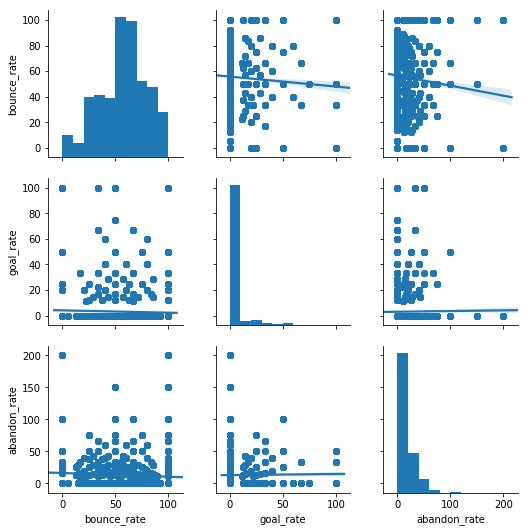

In [18]:
cols = ['bounce_rate','goal_rate', 'abandon_rate']
sns.pairplot(ga_class[cols], kind='reg')
plt.show()

## Proceed to EDA and Statistics

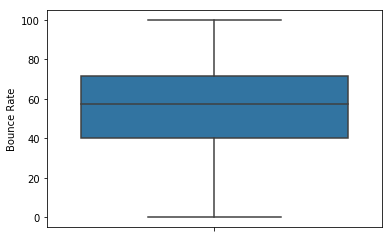

In [19]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='bounce_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Bounce Rate')
# Show the plot
plt.show()

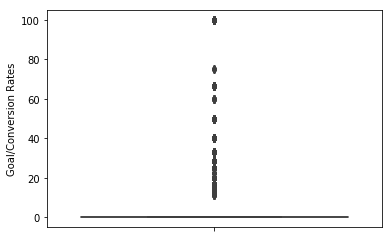

In [20]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='goal_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Goal/Conversion Rates')
# Show the plot
plt.show()

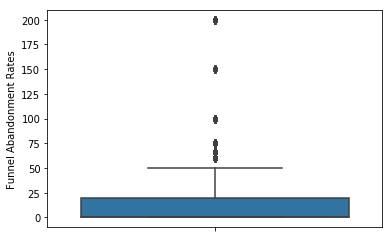

In [21]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='abandon_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Funnel Abandonment Rates')
# Show the plot
plt.show()

In [22]:
# where data is the column that includes the value we are interested
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

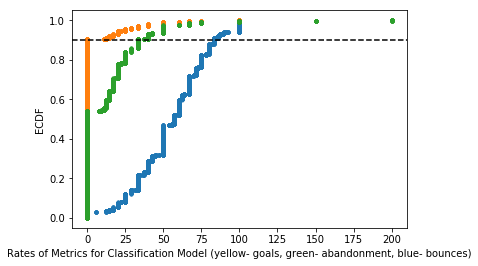

In [35]:
bounces = np.array(ga_class['bounce_rate'])
goals = np.array(ga_class['goal_rate'])
abandons = np.array(ga_class['abandon_rate'])

# Compute ECDF for versicolor data: x_vers, y_vers
x, y = ecdf(bounces)
x2, y2 = ecdf(goals)
x3, y3 = ecdf(abandons)
mean1 =  np.mean(bounces)
median2 =  np.median(goals)
median3 =  np.median(abandons)

# Generate plot
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(x2, y2, marker='.', linestyle='none')
plt.plot(x3, y3, marker='.', linestyle='none')

# Label the axes
plt.xlabel('Rates of Metrics for Classification Model (yellow- goals, green- abandonment, blue- bounces)')
plt.ylabel('ECDF')

# Display the plot
plt.axhline(0.9, color='black', linestyle='--')
plt.show()

In [24]:
display(ga_class['bounce_rate'].describe())
display(ga_class['goal_rate'].describe())
display(ga_class['abandon_rate'].describe())

count    12128.000000
mean        55.464291
std         23.197239
min          0.000000
25%         40.000000
50%         57.140000
75%         71.430000
max        100.000000
Name: bounce_rate, dtype: float64

count    12128.000000
mean         3.065531
std         11.276428
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: goal_rate, dtype: float64

count    12128.000000
mean        12.940953
std         19.900828
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max        200.000000
Name: abandon_rate, dtype: float64

### Bootstrapping the metrics - goals, bounces, and abandons

In [25]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


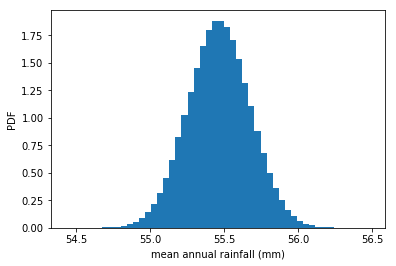

In [26]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates1 = draw_bs_reps(bounces, np.mean, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates1, bins=50,  normed=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [27]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates1 <= np.mean(bounces)) / 1000000

# Print the p-value
print('p = ', p)

p =  0.500363


In [28]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates1, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [55.05199454 55.87762638] games


C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


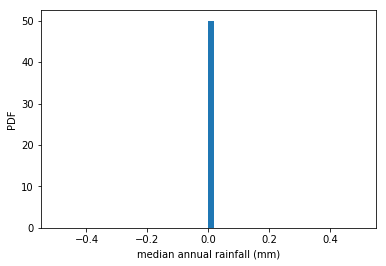

In [29]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates2 = draw_bs_reps(goals, np.median, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates2, bins=50,  normed=True)
_ = plt.xlabel('median annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [30]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates2 <= np.median(goals)) / 1000000

# Print the p-value
print('p = ', p)

p =  1.0


In [31]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates2, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [0. 0.] games


C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


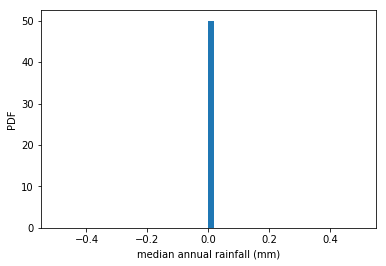

In [32]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates3 = draw_bs_reps(abandons, np.median, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates3, bins=50,  normed=True)
_ = plt.xlabel('median annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [33]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates3 <= np.median(goals)) / 1000000

# Print the p-value
print('p = ', p)

p =  1.0


In [34]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates3, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [0. 0.] games


## Labelling the dataset

## Proceed to Data Modelling

In [ ]:
# preparing the predictor and dependent variables
features = ga_class.columns.tolist()
features.remove('goal1')
features.remove('bounces')
X, y = ga_class.loc[:, features], ga_class.loc[:,'goal1']
print(X.shape)
print(y.shape)

In [ ]:
# Split the data into training and testing data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
#Random Forest Classifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

pl_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])
training_score = cross_val_score(pl_random_forest, X_train, y_train, cv=5, scoring='accuracy')
test_score = cross_val_score(pl_random_forest, X_test, y_test, cv=5, scoring='accuracy')
print('Training Accuracy for RandomForest is : ', training_score.mean())
print('Test Accuracy for RandomForest is : ', test_score.mean())